In [1]:
import sys, os 
import tensorflow as tf 
import matplotlib.pyplot as plt
from tensorflow import keras 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Flatten, Input, Conv2D, Activation, Layer, ReLU, Softmax, BatchNormalization, MaxPool2D, AveragePooling2D, Rescaling, CenterCrop, RandomRotation)
import numpy as np 
import cv2 as cv 
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

# For consistent tests
keras.utils.set_random_seed(1)

2023-03-21 20:34:49.202842: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 20:34:49.258623: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# func to convert .png to .jpg files (.png files have 4 color channels, so regularize input file type with thsi func)
def png_to_jpg(input_dir, output_dir):
    for file in os.listdir(input_dir):
        if file.endswith('.png'):
            filePath = os.path.join(input_dir, file)
            image = cv.imread(filePath)
            output_file = os.path.splitext(file)[0]+".jpg"
            output_filepath = os.path.join(output_dir, output_file)
            cv.imwrite(output_filepath, image)
            os.remove(filePath)
    return

In [3]:
## Read in the images, create class labels, and preprocess for input into CNN ##
#num_classes = 36

path = 'images' # change image path accordingly

# list to store particle (class) names
particle_types = []

# list to store all particle images. This is what will be randomly shuffled and will be train/validation/test split
images = []

for fileName in os.listdir(path):
    
    if not fileName.startswith("."):
        print(fileName)
        sub_dir_path = os.path.join(path, fileName)
        png_to_jpg(sub_dir_path, sub_dir_path)
        particle_types.append(fileName)
        
        if os.path.isdir(sub_dir_path):
            
            # loop over each file in each sub directory and append to a list of images
            for file in os.listdir(sub_dir_path):
             
                # ignore hidden files that your os may generate
                if not file.startswith('.') or not file.endswith('.jpg'):
                    print(file)

                    # create directory path for the image
                    directory = os.path.join(sub_dir_path, file)
                    
                    # read in each image using openCV
                    image = cv.imread(directory)
                    # resize the images accordingly
                    image = cv.resize(image, (75,75))
                    # append to the list we are storing images
                    images.append(image)

antitop quark
20230228_164707.jpg
20221202_185159.jpg
IMG_20221202_185458.jpg
20230228_164715.jpg
Screen Shot 2023-02-07 at 8.46.08 AM.jpg
Screen Shot 2023-02-07 at 9.02.04 AM.jpg
20230228_164702.jpg
Screen Shot 2023-02-07 at 9.18.07 AM.jpg
IMG_20221202_185454.jpg
20230228_164731.jpg
20230228_164658.jpg
20221202_185157.jpg
20230228_164700.jpg
20230228_164704.jpg
electron-neutrino
20230228_170625.jpg
20230228_170623.jpg
20221202_185133.jpg
20221202_185135.jpg
20230228_170633.jpg
IMG_20221202_185529.jpg
Screen Shot 2023-02-07 at 9.00.43 AM.jpg
Screen Shot 2023-02-07 at 8.44.31 AM.jpg
20230228_170630.jpg
20230228_170530.jpg
20230228_170547.jpg
20230228_170555.jpg
20230228_170559.jpg
20230228_170545.jpg
20230228_170528.jpg
20221202_185136.jpg
Screen Shot 2023-02-07 at 9.18.15 AM.jpg
20230228_170627.jpg
20230228_170535.jpg
IMG_20221202_185525.jpg
dark matter
IMG_20221202_185215.jpg
20230228_173354.jpg
20230228_173356.jpg
20230228_173350.jpg
Screen Shot 2023-02-07 at 8.46.51 AM.jpg
Screen Sh

20221202_185740.jpg
20230228_164934.jpg
20230228_164922.jpg
20230228_164928.jpg
20230228_173610.jpg
20230228_164939.jpg
Screen Shot 2023-02-07 at 9.18.21 AM.jpg
20230228_173601.jpg
Screen Shot 2023-02-07 at 8.47.16 AM.jpg
anticharm quark
20230228_173209.jpg
20230228_173207.jpg
Screen Shot 2023-02-07 at 9.00.50 AM.jpg
20221202_185146.jpg
20230228_173202.jpg
20230228_173155.jpg
20230228_173151.jpg
20221202_185148.jpg
20230228_173157.jpg
20230228_173149.jpg
Screen Shot 2023-02-07 at 8.44.40 AM.jpg
20221202_185150.jpg
Screen Shot 2023-02-07 at 9.17.55 AM.jpg
20230228_173213.jpg
20230228_173204.jpg
proton
20221202_185048.jpg
Screen Shot 2023-02-07 at 9.00.34 AM.jpg
20230228_164822.jpg
20230228_164738.jpg
Screen Shot 2023-02-07 at 9.16.18 AM.jpg
20230228_164753.jpg
IMG_20221202_185545.jpg
20230228_164819.jpg
Screen Shot 2023-02-07 at 8.46.48 AM.jpg
20221202_185043.jpg
20230228_164742.jpg
20230228_164748.jpg
20230228_164746.jpg
IMG_20221202_185548.jpg
photon
Screen Shot 2023-02-07 at 9.00.07 

In [4]:
# store images and labels in a dictionary
particle_dict = dict.fromkeys(particle_types)

for fileName in os.listdir(path):
    
    if not fileName.startswith("."):
        particle_dict[fileName] = []
        sub_dir_path = os.path.join(path, fileName)
        if os.path.isdir(sub_dir_path):
            
            # loop over each file in each sub directory and append to a list of images
            for file in os.listdir(sub_dir_path):
                # ignore hidden files that your os may generate
                if not file.startswith('.'):
                    directory = os.path.join(sub_dir_path, file)
                    image = cv.imread(directory)
                    image = cv.resize(image,(75,75))
                    particle_dict[fileName].append(image)    

#train_data, val_data, test_data = train_val_test_split(particle_dict, 0.6, 0.2, 0.2 )
labels = []
for key, value in particle_dict.items():
    for i in range(len(value)):
        labels.append(key)
one_hot_labels = pd.get_dummies(labels).values

images = np.array(images)
        
x_train, x_val, y_train, y_val = train_test_split(images, one_hot_labels, random_state = 1, test_size = 0.1, stratify = one_hot_labels)

x_train, X_test, y_train, Y_test = train_test_split(x_train, y_train, random_state = 1, test_size = 1/9, stratify = y_train)

542
0
Image Data Type: <class 'numpy.ndarray'>
Image shape: (75, 75, 3)
1
Image Data Type: <class 'numpy.ndarray'>
Image shape: (75, 75, 3)
2
Image Data Type: <class 'numpy.ndarray'>
Image shape: (75, 75, 3)
3
Image Data Type: <class 'numpy.ndarray'>
Image shape: (75, 75, 3)
4
Image Data Type: <class 'numpy.ndarray'>
Image shape: (75, 75, 3)
5
Image Data Type: <class 'numpy.ndarray'>
Image shape: (75, 75, 3)
6
Image Data Type: <class 'numpy.ndarray'>
Image shape: (75, 75, 3)
7
Image Data Type: <class 'numpy.ndarray'>
Image shape: (75, 75, 3)
8
Image Data Type: <class 'numpy.ndarray'>
Image shape: (75, 75, 3)
9
Image Data Type: <class 'numpy.ndarray'>
Image shape: (75, 75, 3)
10
Image Data Type: <class 'numpy.ndarray'>
Image shape: (75, 75, 3)
11
Image Data Type: <class 'numpy.ndarray'>
Image shape: (75, 75, 3)
12
Image Data Type: <class 'numpy.ndarray'>
Image shape: (75, 75, 3)
13
Image Data Type: <class 'numpy.ndarray'>
Image shape: (75, 75, 3)
14
Image Data Type: <class 'numpy.ndarra

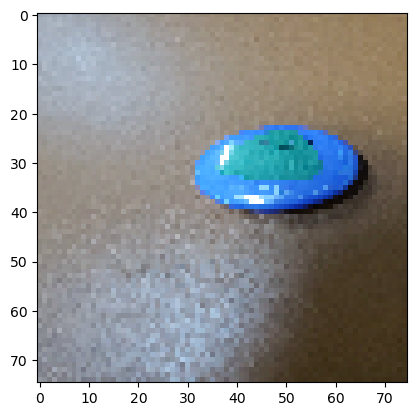

In [5]:
# print out some input data/images and confirm data type (THIS IS UNDERATTED AND OFTEN OVERLLOOKED STEP IN DATA ANALYSIS)
print(len(images))
for i in range(len(images)):
    if type(images[i]) is not None:
        print(i)
        print('Image Data Type:', type(images[i]))
        print('Image shape:', images[i].shape)
plt.imshow(images[0])

In [6]:
## Create your classifier NN. In this case I chose a simple CNN ## 
inputArray = Input((75,75,3))
x = Rescaling(1./255)(inputArray)
x = RandomRotation(0.1)(x)

x = Conv2D(2, 2)(x)
x = keras.activations.relu(x)
x = Conv2D(3, 3)(x)
x = keras.activations.selu(x)
x = MaxPool2D(3,3)(x)
x = Conv2D(3, 3)(x)
x = keras.activations.selu(x)
x = AveragePooling2D(3,3)(x)

x = Flatten()(x)
    
x = keras.layers.AlphaDropout(0.1)(x)
x = keras.layers.BatchNormalization()(x)

x = Dense(5)(x)
x = keras.activations.sigmoid(x)
x = Dense(36)(x)
outputArray = keras.activations.softmax(x)

opt = 'adam'

## create/declare cnn model 
convNet = Model(inputs = inputArray, outputs = outputArray)

convNet.compile(loss = 'categorical_crossentropy',
                metrics = ['accuracy'],
               optimizer = opt)
convNet.summary()
#keras.utils.plot_model(convNet, show_shapes=True)

2023-03-21 20:36:57.702569: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
history = convNet.fit(x_train, y_train, epochs = 1000, batch_size = 35, validation_data = (x_val, y_val))

y_score = convNet.predict(X_test)
y_test_score = convNet.evaluate(X_test, Y_test)

Epoch 1/1000
13/13 [==============================] - 2s 35ms/step - loss: 3.6177 - accuracy: 0.0370 - val_loss: 3.5906 - val_accuracy: 0.0364
Epoch 2/1000
13/13 [==============================] - 0s 22ms/step - loss: 3.6149 - accuracy: 0.0278 - val_loss: 3.5892 - val_accuracy: 0.0545
Epoch 3/1000
13/13 [==============================] - 0s 33ms/step - loss: 3.6055 - accuracy: 0.0347 - val_loss: 3.5870 - val_accuracy: 0.0364
Epoch 4/1000
13/13 [==============================] - 0s 32ms/step - loss: 3.6008 - accuracy: 0.0301 - val_loss: 3.5853 - val_accuracy: 0.0364
Epoch 5/1000
13/13 [==============================] - 0s 31ms/step - loss: 3.6014 - accuracy: 0.0324 - val_loss: 3.5834 - val_accuracy: 0.0364
Epoch 6/1000
13/13 [==============================] - 0s 30ms/step - loss: 3.5954 - accuracy: 0.0324 - val_loss: 3.5811 - val_accuracy: 0.0364
Epoch 7/1000
13/13 [==============================] - 0s 31ms/step - loss: 3.5918 - accuracy: 0.0370 - val_loss: 3.5794 - val_accuracy: 0.0364

13/13 [==============================] - 0s 32ms/step - loss: 3.4620 - accuracy: 0.0579 - val_loss: 3.4983 - val_accuracy: 0.0545
Epoch 50/1000
13/13 [==============================] - 0s 32ms/step - loss: 3.4558 - accuracy: 0.0741 - val_loss: 3.4986 - val_accuracy: 0.0545
Epoch 51/1000
13/13 [==============================] - 0s 31ms/step - loss: 3.4496 - accuracy: 0.0579 - val_loss: 3.4964 - val_accuracy: 0.0727
Epoch 52/1000
13/13 [==============================] - 0s 32ms/step - loss: 3.4571 - accuracy: 0.0556 - val_loss: 3.4878 - val_accuracy: 0.0727
Epoch 53/1000
13/13 [==============================] - 0s 32ms/step - loss: 3.4498 - accuracy: 0.0764 - val_loss: 3.4820 - val_accuracy: 0.0727
Epoch 54/1000
13/13 [==============================] - 0s 31ms/step - loss: 3.4365 - accuracy: 0.0602 - val_loss: 3.4785 - val_accuracy: 0.0727
Epoch 55/1000
13/13 [==============================] - 0s 31ms/step - loss: 3.4327 - accuracy: 0.0602 - val_loss: 3.4815 - val_accuracy: 0.0727
Epoch 

Epoch 106/1000
13/13 [==============================] - 0s 35ms/step - loss: 3.2064 - accuracy: 0.1111 - val_loss: 3.3362 - val_accuracy: 0.0545
Epoch 107/1000
13/13 [==============================] - 0s 35ms/step - loss: 3.2034 - accuracy: 0.1134 - val_loss: 3.3391 - val_accuracy: 0.0545
Epoch 108/1000
13/13 [==============================] - 0s 34ms/step - loss: 3.1784 - accuracy: 0.1227 - val_loss: 3.3451 - val_accuracy: 0.0364
Epoch 109/1000
13/13 [==============================] - 0s 33ms/step - loss: 3.1861 - accuracy: 0.1134 - val_loss: 3.2938 - val_accuracy: 0.0545
Epoch 110/1000
13/13 [==============================] - 0s 30ms/step - loss: 3.1763 - accuracy: 0.1157 - val_loss: 3.3490 - val_accuracy: 0.0364
Epoch 111/1000
13/13 [==============================] - 0s 31ms/step - loss: 3.1799 - accuracy: 0.1296 - val_loss: 3.3454 - val_accuracy: 0.0364
Epoch 112/1000
13/13 [==============================] - 0s 32ms/step - loss: 3.1878 - accuracy: 0.1134 - val_loss: 3.3013 - val_ac

13/13 [==============================] - 0s 31ms/step - loss: 3.0087 - accuracy: 0.1481 - val_loss: 3.2773 - val_accuracy: 0.0545
Epoch 163/1000
13/13 [==============================] - 0s 32ms/step - loss: 3.0358 - accuracy: 0.1250 - val_loss: 3.2979 - val_accuracy: 0.0182
Epoch 164/1000
13/13 [==============================] - 0s 31ms/step - loss: 3.0130 - accuracy: 0.1250 - val_loss: 3.2745 - val_accuracy: 0.0182
Epoch 165/1000
13/13 [==============================] - 0s 32ms/step - loss: 3.0225 - accuracy: 0.1389 - val_loss: 3.2809 - val_accuracy: 0.0364
Epoch 166/1000
13/13 [==============================] - 0s 33ms/step - loss: 3.0134 - accuracy: 0.1227 - val_loss: 3.3029 - val_accuracy: 0.0545
Epoch 167/1000
13/13 [==============================] - 0s 34ms/step - loss: 3.0144 - accuracy: 0.1250 - val_loss: 3.2848 - val_accuracy: 0.0182
Epoch 168/1000
13/13 [==============================] - 0s 35ms/step - loss: 3.0000 - accuracy: 0.1181 - val_loss: 3.2661 - val_accuracy: 0.0182


13/13 [==============================] - 0s 35ms/step - loss: 2.9173 - accuracy: 0.1620 - val_loss: 3.2486 - val_accuracy: 0.0364
Epoch 219/1000
13/13 [==============================] - 0s 35ms/step - loss: 2.9303 - accuracy: 0.1343 - val_loss: 3.2382 - val_accuracy: 0.0182
Epoch 220/1000
13/13 [==============================] - 0s 35ms/step - loss: 2.9052 - accuracy: 0.1458 - val_loss: 3.1916 - val_accuracy: 0.0364
Epoch 221/1000
13/13 [==============================] - 0s 36ms/step - loss: 2.9015 - accuracy: 0.1528 - val_loss: 3.2136 - val_accuracy: 0.0182
Epoch 222/1000
13/13 [==============================] - 0s 37ms/step - loss: 2.9186 - accuracy: 0.1319 - val_loss: 3.2225 - val_accuracy: 0.0364
Epoch 223/1000
13/13 [==============================] - 0s 36ms/step - loss: 2.9088 - accuracy: 0.1481 - val_loss: 3.2210 - val_accuracy: 0.0545
Epoch 224/1000
13/13 [==============================] - 0s 33ms/step - loss: 2.8741 - accuracy: 0.1435 - val_loss: 3.2040 - val_accuracy: 0.0364


13/13 [==============================] - 0s 32ms/step - loss: 2.8209 - accuracy: 0.1782 - val_loss: 3.2079 - val_accuracy: 0.0364
Epoch 275/1000
13/13 [==============================] - 0s 32ms/step - loss: 2.8448 - accuracy: 0.1690 - val_loss: 3.2204 - val_accuracy: 0.0364
Epoch 276/1000
13/13 [==============================] - 0s 25ms/step - loss: 2.8606 - accuracy: 0.1736 - val_loss: 3.2280 - val_accuracy: 0.0364
Epoch 277/1000
13/13 [==============================] - 0s 32ms/step - loss: 2.8349 - accuracy: 0.1875 - val_loss: 3.2660 - val_accuracy: 0.0182
Epoch 278/1000
13/13 [==============================] - 0s 29ms/step - loss: 2.8143 - accuracy: 0.1574 - val_loss: 3.2519 - val_accuracy: 0.0364
Epoch 279/1000
13/13 [==============================] - 0s 22ms/step - loss: 2.8146 - accuracy: 0.1875 - val_loss: 3.2254 - val_accuracy: 0.0364
Epoch 280/1000
13/13 [==============================] - 0s 32ms/step - loss: 2.8077 - accuracy: 0.1690 - val_loss: 3.1782 - val_accuracy: 0.0364


13/13 [==============================] - 0s 32ms/step - loss: 2.7708 - accuracy: 0.1505 - val_loss: 3.2246 - val_accuracy: 0.0364
Epoch 331/1000
13/13 [==============================] - 0s 31ms/step - loss: 2.7345 - accuracy: 0.1852 - val_loss: 3.1857 - val_accuracy: 0.0545
Epoch 332/1000
13/13 [==============================] - 0s 32ms/step - loss: 2.7288 - accuracy: 0.1690 - val_loss: 3.1748 - val_accuracy: 0.0545
Epoch 333/1000
13/13 [==============================] - 0s 33ms/step - loss: 2.7552 - accuracy: 0.1713 - val_loss: 3.1752 - val_accuracy: 0.0364
Epoch 334/1000
13/13 [==============================] - 0s 36ms/step - loss: 2.7431 - accuracy: 0.1574 - val_loss: 3.2053 - val_accuracy: 0.0545
Epoch 335/1000
13/13 [==============================] - 0s 35ms/step - loss: 2.7286 - accuracy: 0.1690 - val_loss: 3.2318 - val_accuracy: 0.0364
Epoch 336/1000
13/13 [==============================] - 0s 36ms/step - loss: 2.7588 - accuracy: 0.1667 - val_loss: 3.2418 - val_accuracy: 0.0545


13/13 [==============================] - 0s 32ms/step - loss: 2.6988 - accuracy: 0.1713 - val_loss: 3.1828 - val_accuracy: 0.0727
Epoch 387/1000
13/13 [==============================] - 0s 32ms/step - loss: 2.6711 - accuracy: 0.2060 - val_loss: 3.1642 - val_accuracy: 0.0727
Epoch 388/1000
13/13 [==============================] - 0s 32ms/step - loss: 2.6869 - accuracy: 0.1852 - val_loss: 3.1895 - val_accuracy: 0.0909
Epoch 389/1000
13/13 [==============================] - 0s 32ms/step - loss: 2.6975 - accuracy: 0.1528 - val_loss: 3.1311 - val_accuracy: 0.1091
Epoch 390/1000
13/13 [==============================] - 0s 32ms/step - loss: 2.6703 - accuracy: 0.1991 - val_loss: 3.1342 - val_accuracy: 0.0909
Epoch 391/1000
13/13 [==============================] - 0s 35ms/step - loss: 2.6599 - accuracy: 0.1806 - val_loss: 3.1370 - val_accuracy: 0.0909
Epoch 392/1000
13/13 [==============================] - 0s 35ms/step - loss: 2.6843 - accuracy: 0.1921 - val_loss: 3.1387 - val_accuracy: 0.0727


13/13 [==============================] - 0s 33ms/step - loss: 2.6133 - accuracy: 0.1968 - val_loss: 3.2181 - val_accuracy: 0.0909
Epoch 443/1000
13/13 [==============================] - 0s 28ms/step - loss: 2.6337 - accuracy: 0.1898 - val_loss: 3.1915 - val_accuracy: 0.0909
Epoch 444/1000
13/13 [==============================] - 0s 30ms/step - loss: 2.6258 - accuracy: 0.1968 - val_loss: 3.1783 - val_accuracy: 0.0909
Epoch 445/1000
13/13 [==============================] - 0s 31ms/step - loss: 2.6327 - accuracy: 0.1806 - val_loss: 3.1678 - val_accuracy: 0.0909
Epoch 446/1000
13/13 [==============================] - 0s 32ms/step - loss: 2.6428 - accuracy: 0.2106 - val_loss: 3.1672 - val_accuracy: 0.0727
Epoch 447/1000
13/13 [==============================] - 0s 32ms/step - loss: 2.6153 - accuracy: 0.2083 - val_loss: 3.1741 - val_accuracy: 0.0909
Epoch 448/1000
13/13 [==============================] - 0s 30ms/step - loss: 2.6350 - accuracy: 0.2153 - val_loss: 3.1617 - val_accuracy: 0.0727


13/13 [==============================] - 0s 31ms/step - loss: 2.5720 - accuracy: 0.2431 - val_loss: 3.1489 - val_accuracy: 0.0727
Epoch 499/1000
13/13 [==============================] - 0s 32ms/step - loss: 2.5857 - accuracy: 0.2222 - val_loss: 3.1810 - val_accuracy: 0.0727
Epoch 500/1000
13/13 [==============================] - 0s 32ms/step - loss: 2.5477 - accuracy: 0.2176 - val_loss: 3.1869 - val_accuracy: 0.0727
Epoch 501/1000
13/13 [==============================] - 0s 35ms/step - loss: 2.5307 - accuracy: 0.1921 - val_loss: 3.2051 - val_accuracy: 0.0545
Epoch 502/1000
13/13 [==============================] - 0s 35ms/step - loss: 2.5343 - accuracy: 0.2176 - val_loss: 3.2181 - val_accuracy: 0.0727
Epoch 503/1000
13/13 [==============================] - 0s 29ms/step - loss: 2.5614 - accuracy: 0.2176 - val_loss: 3.2591 - val_accuracy: 0.0545
Epoch 504/1000
13/13 [==============================] - 0s 28ms/step - loss: 2.5500 - accuracy: 0.2014 - val_loss: 3.2880 - val_accuracy: 0.0545


13/13 [==============================] - 0s 38ms/step - loss: 2.5503 - accuracy: 0.2083 - val_loss: 3.2574 - val_accuracy: 0.0364
Epoch 555/1000
13/13 [==============================] - 0s 33ms/step - loss: 2.5105 - accuracy: 0.2176 - val_loss: 3.2403 - val_accuracy: 0.0545
Epoch 556/1000
13/13 [==============================] - 0s 37ms/step - loss: 2.4927 - accuracy: 0.2431 - val_loss: 3.2811 - val_accuracy: 0.0364
Epoch 557/1000
13/13 [==============================] - 0s 36ms/step - loss: 2.5125 - accuracy: 0.1991 - val_loss: 3.2537 - val_accuracy: 0.0545
Epoch 558/1000
13/13 [==============================] - 0s 36ms/step - loss: 2.4999 - accuracy: 0.2130 - val_loss: 3.2451 - val_accuracy: 0.0545
Epoch 559/1000
13/13 [==============================] - 0s 35ms/step - loss: 2.5380 - accuracy: 0.1968 - val_loss: 3.2086 - val_accuracy: 0.0364
Epoch 560/1000
13/13 [==============================] - 0s 36ms/step - loss: 2.5114 - accuracy: 0.2315 - val_loss: 3.1843 - val_accuracy: 0.0364


13/13 [==============================] - 0s 32ms/step - loss: 2.4915 - accuracy: 0.2083 - val_loss: 3.2796 - val_accuracy: 0.0364
Epoch 611/1000
13/13 [==============================] - 0s 27ms/step - loss: 2.4937 - accuracy: 0.2014 - val_loss: 3.2445 - val_accuracy: 0.0182
Epoch 612/1000
13/13 [==============================] - 0s 30ms/step - loss: 2.5322 - accuracy: 0.1991 - val_loss: 3.2236 - val_accuracy: 0.0727
Epoch 613/1000
13/13 [==============================] - 0s 32ms/step - loss: 2.4726 - accuracy: 0.2130 - val_loss: 3.2019 - val_accuracy: 0.0364
Epoch 614/1000
13/13 [==============================] - 0s 32ms/step - loss: 2.4757 - accuracy: 0.2222 - val_loss: 3.2132 - val_accuracy: 0.0727
Epoch 615/1000
13/13 [==============================] - 0s 27ms/step - loss: 2.4453 - accuracy: 0.2338 - val_loss: 3.1521 - val_accuracy: 0.0545
Epoch 616/1000
13/13 [==============================] - 0s 21ms/step - loss: 2.4943 - accuracy: 0.2060 - val_loss: 3.2053 - val_accuracy: 0.0545


13/13 [==============================] - 0s 32ms/step - loss: 2.3969 - accuracy: 0.2176 - val_loss: 3.3105 - val_accuracy: 0.0545
Epoch 667/1000
13/13 [==============================] - 0s 31ms/step - loss: 2.4787 - accuracy: 0.1944 - val_loss: 3.3305 - val_accuracy: 0.0364
Epoch 668/1000
13/13 [==============================] - 0s 31ms/step - loss: 2.4346 - accuracy: 0.2454 - val_loss: 3.3444 - val_accuracy: 0.0364
Epoch 669/1000
13/13 [==============================] - 0s 31ms/step - loss: 2.4177 - accuracy: 0.2454 - val_loss: 3.3379 - val_accuracy: 0.0364
Epoch 670/1000
13/13 [==============================] - 0s 31ms/step - loss: 2.4475 - accuracy: 0.2106 - val_loss: 3.2863 - val_accuracy: 0.0727
Epoch 671/1000
13/13 [==============================] - 0s 32ms/step - loss: 2.3992 - accuracy: 0.2407 - val_loss: 3.3180 - val_accuracy: 0.0182
Epoch 672/1000
13/13 [==============================] - 0s 23ms/step - loss: 2.3968 - accuracy: 0.2361 - val_loss: 3.3090 - val_accuracy: 0.0364


13/13 [==============================] - 0s 31ms/step - loss: 2.3988 - accuracy: 0.2199 - val_loss: 3.2932 - val_accuracy: 0.0364
Epoch 723/1000
13/13 [==============================] - 0s 32ms/step - loss: 2.3592 - accuracy: 0.2477 - val_loss: 3.3208 - val_accuracy: 0.0545
Epoch 724/1000
13/13 [==============================] - 0s 32ms/step - loss: 2.3770 - accuracy: 0.2593 - val_loss: 3.3244 - val_accuracy: 0.0364
Epoch 725/1000
13/13 [==============================] - 0s 32ms/step - loss: 2.3959 - accuracy: 0.2338 - val_loss: 3.3533 - val_accuracy: 0.0364
Epoch 726/1000
13/13 [==============================] - 0s 31ms/step - loss: 2.3730 - accuracy: 0.2477 - val_loss: 3.3953 - val_accuracy: 0.0545
Epoch 727/1000
13/13 [==============================] - 0s 30ms/step - loss: 2.4044 - accuracy: 0.2315 - val_loss: 3.3562 - val_accuracy: 0.0545
Epoch 728/1000
13/13 [==============================] - 0s 32ms/step - loss: 2.3961 - accuracy: 0.2500 - val_loss: 3.3490 - val_accuracy: 0.0182


13/13 [==============================] - 0s 35ms/step - loss: 2.3901 - accuracy: 0.2361 - val_loss: 3.1445 - val_accuracy: 0.0545
Epoch 779/1000
13/13 [==============================] - 0s 35ms/step - loss: 2.3831 - accuracy: 0.2477 - val_loss: 3.2008 - val_accuracy: 0.0545
Epoch 780/1000
13/13 [==============================] - 0s 34ms/step - loss: 2.4243 - accuracy: 0.2292 - val_loss: 3.2287 - val_accuracy: 0.0909
Epoch 781/1000
13/13 [==============================] - 0s 35ms/step - loss: 2.3601 - accuracy: 0.2569 - val_loss: 3.1919 - val_accuracy: 0.0364
Epoch 782/1000
13/13 [==============================] - 0s 35ms/step - loss: 2.3432 - accuracy: 0.2523 - val_loss: 3.1734 - val_accuracy: 0.0545
Epoch 783/1000
13/13 [==============================] - 0s 35ms/step - loss: 2.3611 - accuracy: 0.2569 - val_loss: 3.1457 - val_accuracy: 0.0727
Epoch 784/1000
13/13 [==============================] - 0s 35ms/step - loss: 2.4189 - accuracy: 0.2431 - val_loss: 3.1444 - val_accuracy: 0.0727


13/13 [==============================] - 0s 35ms/step - loss: 2.3767 - accuracy: 0.2407 - val_loss: 3.3953 - val_accuracy: 0.0545
Epoch 835/1000
13/13 [==============================] - 0s 34ms/step - loss: 2.3283 - accuracy: 0.2662 - val_loss: 3.4504 - val_accuracy: 0.0364
Epoch 836/1000
13/13 [==============================] - 0s 35ms/step - loss: 2.3265 - accuracy: 0.2685 - val_loss: 3.4208 - val_accuracy: 0.0364
Epoch 837/1000
13/13 [==============================] - 0s 36ms/step - loss: 2.3495 - accuracy: 0.2292 - val_loss: 3.4445 - val_accuracy: 0.0727
Epoch 838/1000
13/13 [==============================] - 0s 35ms/step - loss: 2.3412 - accuracy: 0.2454 - val_loss: 3.3762 - val_accuracy: 0.0909
Epoch 839/1000
13/13 [==============================] - 0s 35ms/step - loss: 2.2894 - accuracy: 0.2569 - val_loss: 3.3441 - val_accuracy: 0.0545
Epoch 840/1000
13/13 [==============================] - 0s 35ms/step - loss: 2.3471 - accuracy: 0.2500 - val_loss: 3.2945 - val_accuracy: 0.0364


13/13 [==============================] - 0s 35ms/step - loss: 2.3014 - accuracy: 0.2616 - val_loss: 3.1399 - val_accuracy: 0.0545
Epoch 891/1000
13/13 [==============================] - 0s 35ms/step - loss: 2.3726 - accuracy: 0.2662 - val_loss: 3.1875 - val_accuracy: 0.0727
Epoch 892/1000
13/13 [==============================] - 0s 33ms/step - loss: 2.3282 - accuracy: 0.2569 - val_loss: 3.0832 - val_accuracy: 0.0909
Epoch 893/1000
13/13 [==============================] - 0s 36ms/step - loss: 2.3693 - accuracy: 0.2361 - val_loss: 3.1226 - val_accuracy: 0.0909
Epoch 894/1000
13/13 [==============================] - 0s 33ms/step - loss: 2.3532 - accuracy: 0.2245 - val_loss: 3.1771 - val_accuracy: 0.1273
Epoch 895/1000
13/13 [==============================] - 0s 35ms/step - loss: 2.2923 - accuracy: 0.2523 - val_loss: 3.1780 - val_accuracy: 0.0727
Epoch 896/1000
13/13 [==============================] - 0s 35ms/step - loss: 2.3353 - accuracy: 0.2477 - val_loss: 3.2094 - val_accuracy: 0.0727


13/13 [==============================] - 0s 36ms/step - loss: 2.3149 - accuracy: 0.2338 - val_loss: 3.2771 - val_accuracy: 0.1091
Epoch 947/1000
13/13 [==============================] - 0s 35ms/step - loss: 2.2383 - accuracy: 0.3009 - val_loss: 3.3070 - val_accuracy: 0.0909
Epoch 948/1000
13/13 [==============================] - 0s 34ms/step - loss: 2.2569 - accuracy: 0.2616 - val_loss: 3.3130 - val_accuracy: 0.0909
Epoch 949/1000
13/13 [==============================] - 0s 35ms/step - loss: 2.2724 - accuracy: 0.2870 - val_loss: 3.2626 - val_accuracy: 0.0909
Epoch 950/1000
13/13 [==============================] - 0s 33ms/step - loss: 2.3214 - accuracy: 0.2454 - val_loss: 3.2343 - val_accuracy: 0.0909
Epoch 951/1000
13/13 [==============================] - 0s 35ms/step - loss: 2.2525 - accuracy: 0.2708 - val_loss: 3.2474 - val_accuracy: 0.0909
Epoch 952/1000
13/13 [==============================] - 0s 35ms/step - loss: 2.2708 - accuracy: 0.2731 - val_loss: 3.1976 - val_accuracy: 0.0909


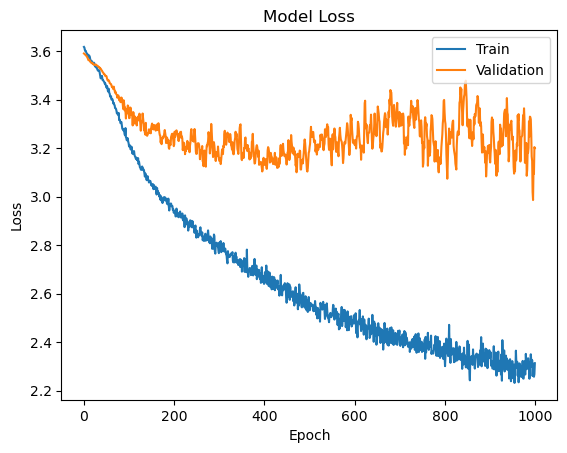

In [72]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Plotting ROC for labels ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35']


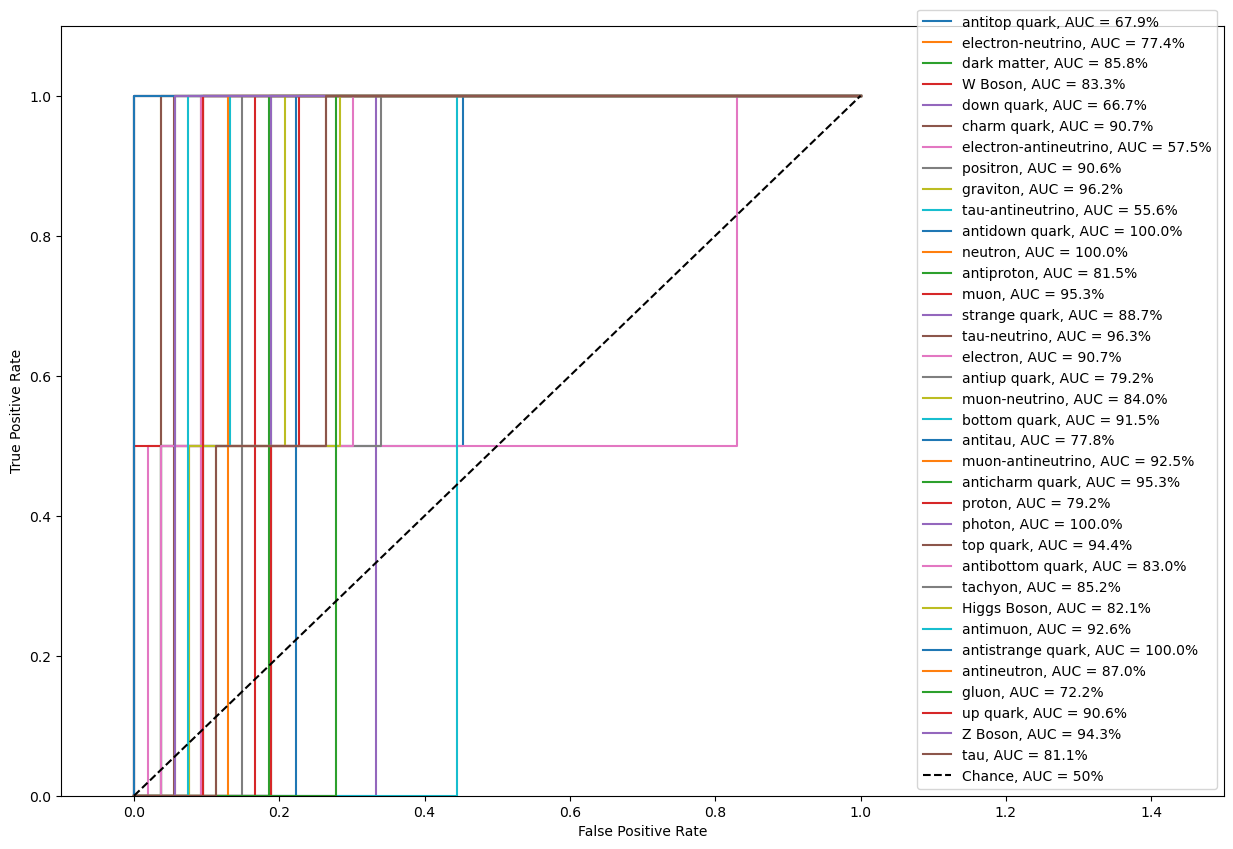

In [73]:
# ROC Curve for each class
df = pd.DataFrame()
fpr  = {}
tpr  = {}
auc1 = {}
labels=['%i'%nr for nr in range (0,36)]
print('Plotting ROC for labels {}'.format(labels))

fig, ax = plt.subplots(figsize=(15, 10))
for i, label in enumerate(labels):
    df[label] = Y_test[:,int(label)]
    df[label + '_pred'] = y_score[:, int(label)]
    fpr[label], tpr[label], threshold = metrics.roc_curve(df[label],df[label+'_pred'])
    auc1[label] = metrics.auc(fpr[label], tpr[label])
    
    plt.plot(fpr[label],tpr[label], label=r'{}, AUC = {:.1f}%'.format(particle_types[int(label)],auc1[label]*100))

plt.plot([0,1], [0,1], "k--", label="Chance, AUC = 50%")
    
#plt.semilogx()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.xlim(-0.1,1.5)
plt.ylim(0,1.1)
plt.legend(loc='lower right')
plt.show()

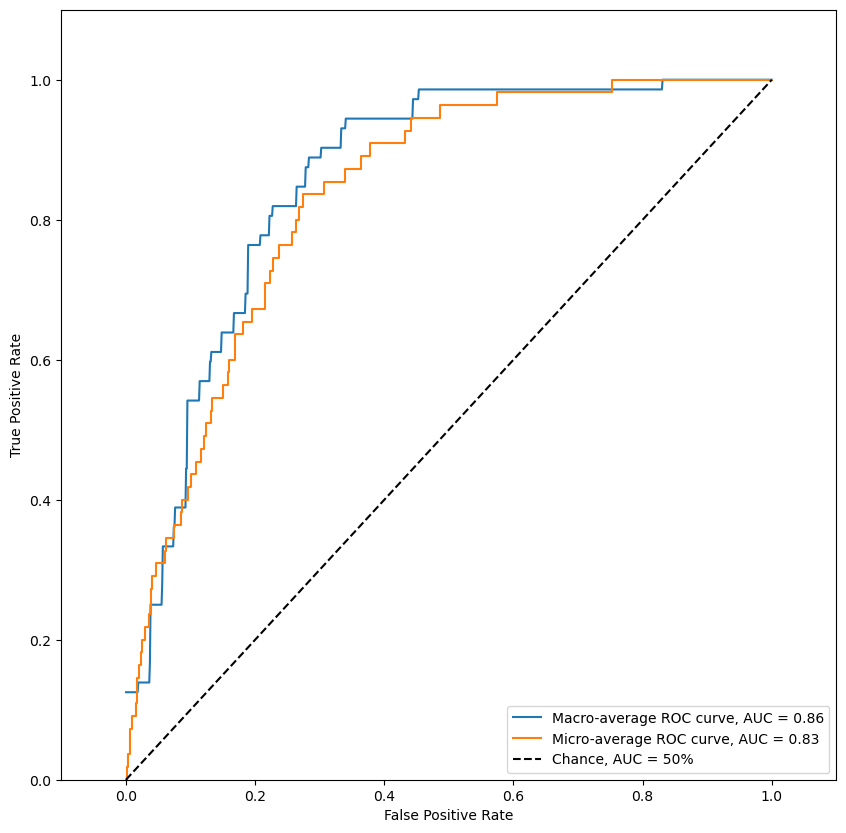

In [74]:
fig, ax = plt.subplots(figsize=(10, 10))

# Macro Average One vs Rest
macro_fpr = {}
macro_tpr = {}
macro_auc = {}
n_classes = 36
for i in range(n_classes):
    macro_fpr[i], macro_tpr[i], _ = metrics.roc_curve(Y_test[:, i], y_score[:, i])
    macro_auc[i] = metrics.auc(macro_fpr[i], macro_tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, macro_fpr[i], macro_tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

macro_auc = metrics.auc(fpr_grid, mean_tpr)

plt.plot(
    fpr_grid,
    mean_tpr,
    label=f"Macro-average ROC curve, AUC = {macro_auc:.2f}",
)

# Micro Average One vs Rest
test_ravel = Y_test.ravel()
pred_ravel = y_score.ravel()
micro_fpr, micro_tpr, threshold = metrics.roc_curve(test_ravel, pred_ravel)
auc = metrics.auc(micro_fpr, micro_tpr)
    
plt.plot(micro_fpr,micro_tpr, label=f"Micro-average ROC curve, AUC = {auc:.2f}")

plt.plot([0,1], [0,1], "k--", label="Chance, AUC = 50%")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.xlim(-0.1,1.1)
plt.ylim(0,1.1)
plt.legend(loc='lower right')
plt.show()